### 数据获取与预处理

数据Microsoft 资讯推荐：https://mind201910small.blob.core.windows.net/release/MINDlarge_train.zip

In [1]:
import os
import shutil
import urllib
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns


temp_dir = os.path.join(os.getcwd(), 'data/MINDlarge_train')
os.makedirs(temp_dir, exist_ok=True)
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_large_url = f'{base_url}/MINDlarge_train.zip'

利用pandas解析数据，查看`news_df`，保留三列---`id`、`category`和`subcategory`，去除其他列。

In [2]:
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
behaviors_df = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
news_path = os.path.join(temp_dir, 'news.tsv')
news_df = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])
news_df = news_df.drop(columns=['title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
news_df.head(10)

,id,category,subcategory
0,N88753,lifestyle,lifestyleroyals
1,N45436,news,newsscienceandtechnology
2,N23144,health,weightloss
3,N86255,health,medical
4,N93187,news,newsworld
5,N75236,health,voices
6,N99744,health,medical
7,N5771,health,cardio
8,N124534,sports,football_nfl
9,N51947,news,newsscienceandtechnology


同上操作，保留`impressions`中被点击的数据，去除其他列。

In [3]:
def extract_positive_ids(cell):
    parts = cell.split()
    return " ".join([part.split('-')[0] for part in parts if part.endswith('-1')])

behaviors_df["impressions"] = behaviors_df["impressions"].apply(extract_positive_ids)
behaviors_df = behaviors_df.drop(columns=['impression_id', 'user_id', 'time'])
behaviors_df.head(10)

,history,impressions
0,N8668 N39081 N65259 N79529 N73408 N43615 N2937...,N94157 N78699 N71090 N31174
1,N56056 N8726 N70353 N67998 N83823 N111108 N107...,N25587 N36266
2,N128643 N87446 N122948 N9375 N82348 N129412 N5...,N47925
3,N31043 N39592 N4104 N8223 N114581 N92747 N1207...,N114935
4,N65250 N122359 N71723 N53796 N41663 N41484 N11...,N86258
5,N8668 N29136 N128643 N9740 N9375 N52911 N12090...,N98178
6,N91810 N96438 N104027 N53650,N94572
7,N9740 N59820 N18389 N23320 N12322 N9375 N11563...,N98178
8,N67770 N65823 N35599 N8753 N126368 N32221 N844...,N123077
9,N14678 N71340 N65259 N92085 N31043 N70385 N123...,N28902


查看两个表的数据规模以更好的分析数据。

In [4]:
news_df.dropna(subset=['category', 'subcategory'], inplace=True)
behaviors_df.dropna(subset=['history', 'impressions'], inplace=True)
print('len news_df:', len(news_df))
print('len behaviors_df:', len(behaviors_df))

len news_df: 101527
len behaviors_df: 2186683


查看`news_df`中不同类比/子类别（这里只展示出现次数前15的子类）的新闻数量。

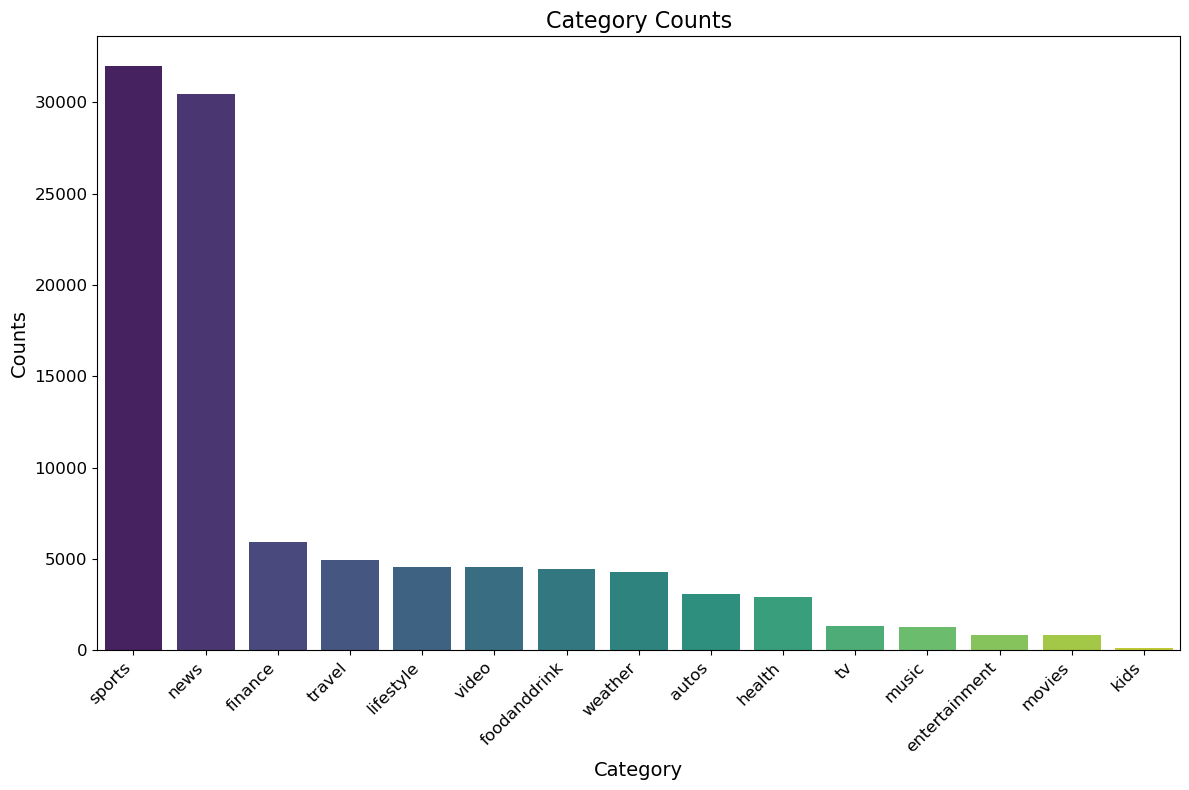

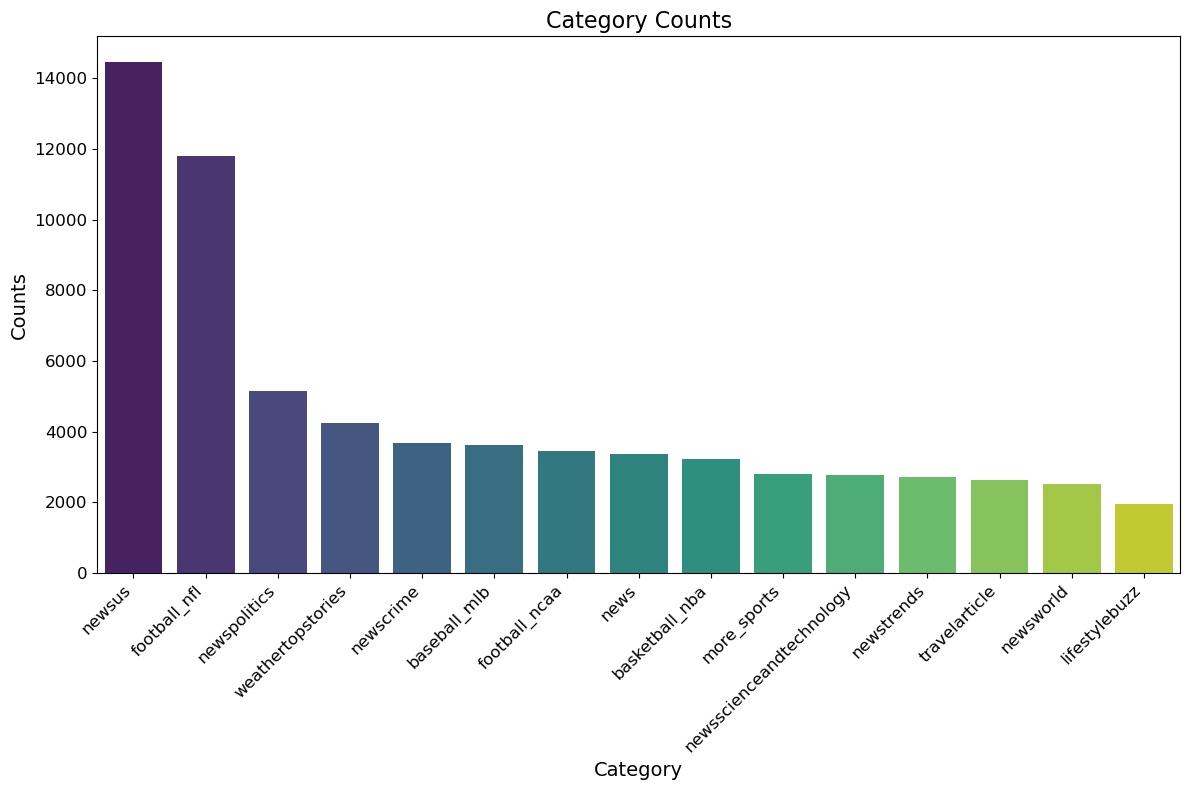

In [6]:
def plot_category_counts(df, column_name, top_n=15):
    plt.figure(figsize=(12, 8))
    sns.barplot(x=df[column_name].value_counts().index[:top_n], y=df[column_name].value_counts().values[:top_n], palette='viridis')
    plt.title('Category Counts', fontsize=16)
    plt.xlabel('Category', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

plot_category_counts(news_df, 'category')
plot_category_counts(news_df, 'subcategory')


将`behaviors_df`的`history`和`impressions`字段中的新闻ID，替换其在`news_df`中对应的子类别。

In [7]:
id_to_subcategory = dict(zip(news_df['id'], news_df['subcategory']))

def ids_to_subcategories(ids):
    return ' '.join(id_to_subcategory.get(news_id, '') for news_id in ids.split())

behaviors_df['history'] = behaviors_df['history'].apply(
    ids_to_subcategories)
behaviors_df['impressions'] = behaviors_df['impressions'].apply(
    ids_to_subcategories)
behaviors_df.head(10)

,history,impressions
0,tv-celebrity newspolitics musicnews nutrition ...,movies-celebrity newspolitics newsus musicnews
1,travelnews football_ncaa_videos news traveltri...,newsus music-celebrity
2,tv-celebrity movies-celebrity animals tv-celeb...,newscrime
3,newsus lifestylebuzz movies-celebrity entertai...,foodnews
4,markets movienews movies-celebrity newsworld n...,animals
5,tv-celebrity lifestylebuzz tv-celebrity newscr...,football_nfl
6,music-celebrity lifestylebuzz finance-real-est...,newsus
7,newscrime football_nfl foodnews movies-gallery...,football_nfl
8,baseball_mlb newscrime newsus lifestyle celebr...,musicnews
9,baseball_mlb football_ncaa musicnews health-ne...,football_ncaa


### 频繁模式挖掘

由于FP-growth算法比Apriori算法执行速度快，能更高效地发现频繁项集，因此使用`fpgrowth`挖掘频繁项集。

In [8]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth



def find_frequent_patterns(behaviors_df):
    transactions = behaviors_df['history'].apply(
        lambda x: x.split()) + behaviors_df['impressions'].apply(lambda x: x.split())

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = fpgrowth(df, min_support=0.1, use_colnames=True)
    return frequent_itemsets


frequent_itemsets = find_frequent_patterns(behaviors_df)
print(frequent_itemsets)

       support                         itemsets
0     0.767892                         (newsus)
1     0.557694                   (tv-celebrity)
2     0.533670                   (newspolitics)
3     0.523931                  (lifestylebuzz)
4     0.412645               (movies-celebrity)
...        ...                              ...
2950  0.106111           (tv-celebrity, voices)
2951  0.105330              (newscrime, voices)
2952  0.100047              (newsworld, voices)
2953  0.102809  (newsus, lifestylebuzz, voices)
2954  0.100188      (newsus, newscrime, voices)

[2955 rows x 2 columns]


### 模式命名与分析

最频繁的项目是 "newsus"，支持度为 0.898。
其他频繁项集包括 tv-celebritye"、newspoliticss和、lifestylebuzzv的支持度也在0.5以上，这些都是较为热门的项目。别
<br>
通过对频繁项集的分析，新闻平台可以更好地了解用户需求，优化内容推荐和分类系统，提高用户体验和内容吸引力，从而增强平台竞争力和持续发展能力。

模式命名：新闻类别模式

### 可视化展示

利用`networkx`可视化新闻子类别之间的关系。

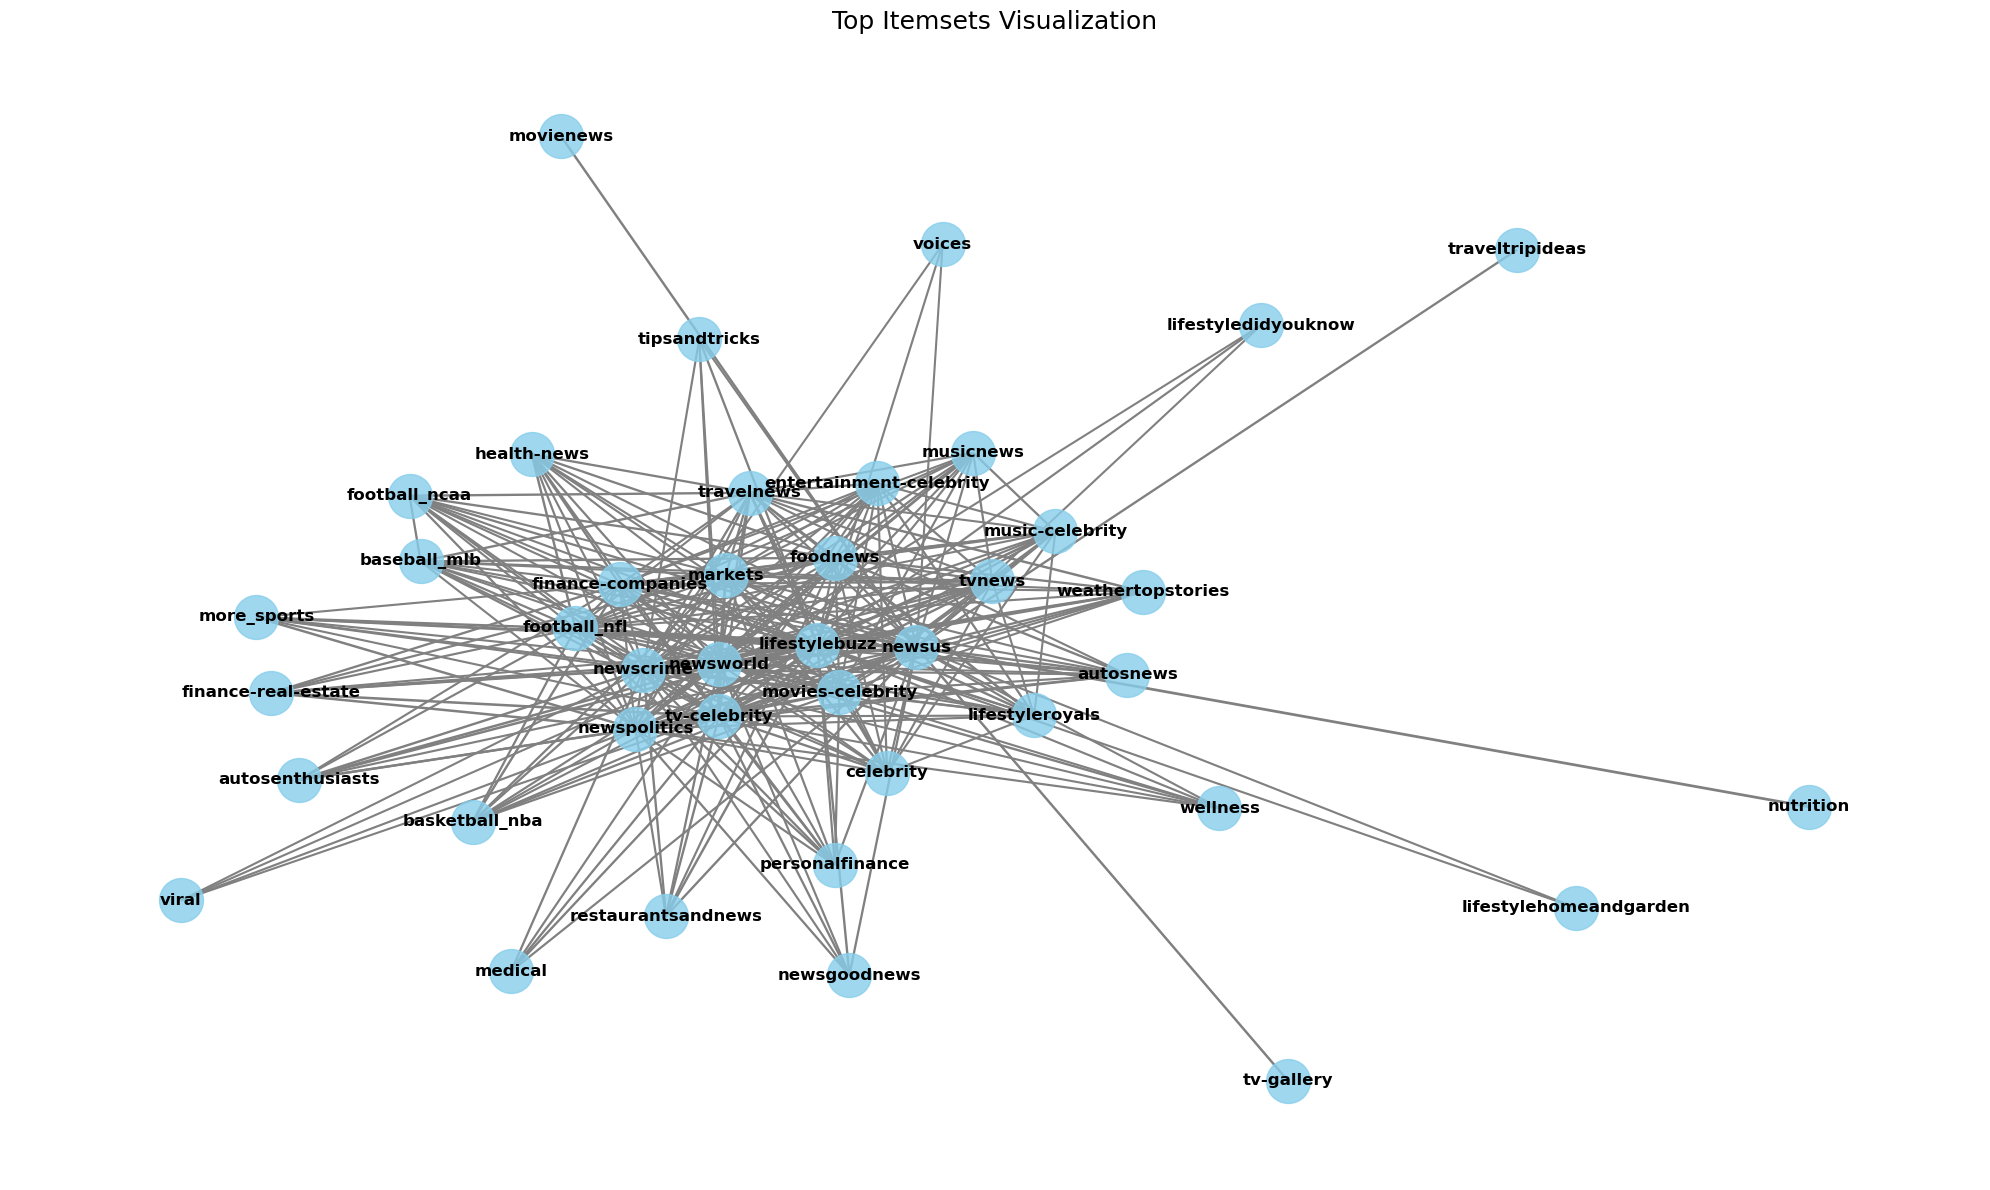

In [10]:
import networkx as nx

def visualize_top_itemsets(frequent_itemsets, top_n=1):
    plt.figure(figsize=(20, 12))
    frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)

    selected_items = set()

    # 遍历排序后的项集，直到收集到足够的独特项目
    for items in frequent_itemsets_sorted['itemsets']:
        selected_items.update(items)
        if len(selected_items) >= top_n:
            break

    filtered_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: any(item in x for item in selected_items))]

    G = nx.Graph()
    for index, row in filtered_itemsets.iterrows():
        items = list(row['itemsets'])
        support = row['support']

        if len(items) > 1:
            for i in range(len(items)):
                for j in range(i + 1, len(items)):
                    G.add_edge(items[i], items[j], weight=support)
        else:
            G.add_node(items[0])

    pos = nx.spring_layout(G, k=0.5, iterations=50)

    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue', alpha=0.8)

    weights = [G[u][v]['weight']*15 for u, v in G.edges()]

    nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', font_weight='bold')

    plt.title('Top Itemsets Visualization', fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_top_itemsets(frequent_itemsets)
